## this codes are used to make visitors number prediction and make a heatmap for chinatown

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from io import BytesIO
from scipy import stats
import datetime

In [3]:
path = r'E:\UCL\BENV0114\CHINATOWN\alldata' ### customize this path to excute following codes

### below codes are pre-processing data and manipulating data from different files

In [4]:
metadata = pd.read_csv(path+'\metadata.csv')

In [5]:
metadata.name = metadata.name.apply(lambda x: x.replace('/','').replace('|','').replace('<','').replace('>',''))

In [27]:
os.chdir(path+'\Monthly comments')

In [28]:
names = [i.replace('.csv','') for i in os.listdir()]

In [29]:
file_names = [i.replace('/','')+'.csv' for i in metadata.name.values.tolist()]

### load popularity time data and visualize it

(array([104.,  10.,   0.,   1.,   2.,   0.,   0.,   0.,   0.,   1.]),
 array([144.0, 6331.5, 12519.0, 18706.5, 24894.0, 31081.5, 37269.0,
        43456.5, 49644.0, 55831.5, 62019.0], dtype=object),
 <a list of 10 Patch objects>)

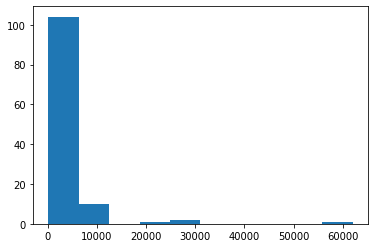

In [30]:
num_reviews = pd.read_csv(path+'\num_reviews.csv')
reviews_week = pd.DataFrame([num_reviews.name,((num_reviews.num_reviews.apply(lambda x: max(x,1)))*625*12/52).apply(round)]).T
pd.set_option('display.max_rows', 118)
plt.hist(reviews_week.num_reviews.values)

In [31]:
os.chdir(path+'\Popularity')
names = os.listdir()
times_list = []
with_time_namelist = []
without_time_namelist = []
for ind,i in enumerate(names):
    with open(path+'\Popularity\{0}'.format(i),encoding='utf-8') as f:
        pt = json.loads(f.read())
        try:
            #print(pt['populartimes'])
            times = np.array([each['data'] for each in pt['populartimes']])
            times_list.append(((times).round().astype(int)))
            with_time_namelist.append(pt['name'])
        except:
            without_time_namelist.append(pt['name'])
            #print('no times')
            continue

### following codes use the mean of popularity time to represent that of sites which do not have such data, and make transformation on data for better visualization

In [33]:
days = 7*24

In [34]:
def MinMaxNormal(x,a,b):
    Min = np.min(x.min())
    Max = np.max(x.max())
    x_normal = ((x-Min)*(b-a))/(Max-Min)
    return x_normal

In [35]:
startdate = datetime.datetime(2020,3,2)
date_index = [(startdate+datetime.timedelta(hours = i)) for i in range(7*24)]

num_vis = pd.DataFrame(columns=['place_id']+date_index)
for ind,i in enumerate(names):
    with open(path+'\Popularity\{0}'.format(i),encoding='utf-8') as f:
        pt = json.loads(f.read())
        try:
            times = np.array([each['data'] for each in pt['populartimes']])
        except:
            mean = np.mean(np.array(times_list),axis = 0).astype(int).reshape(-1,)
            mode = stats.mode(np.array(times_list),axis = 0)[0].reshape(-1,)
            times = np.mean(np.c_[mean,mode],axis = 1).round(0)
            times = ((times/times.max())*100).round(0)

        num_vis.loc[ind,'place_id'] = pt['id']
        num_vis.loc[ind,date_index] = times.reshape(1,days)
org_numvis = num_vis.loc[:,date_index].copy()
num_vis = num_vis.join(metadata.loc[:,['name','place_id']].set_index('place_id'),on = 'place_id')
num_vis = num_vis.join(num_reviews.set_index('name'),on = 'name')

coef_org = []

for i in range(num_vis.shape[0]):
    coef = ((num_vis.loc[i,date_index]/num_vis.loc[i,date_index].sum())*max(num_vis.loc[i,'num_reviews']*12,1)/52*700)
    coef_org.append(coef)
    num_vis.loc[i,date_index] = num_vis.loc[i,date_index]+25*coef.apply(lambda x:np.log(x+1e-4)) ### equation (3) in the report
    
coef_org = pd.DataFrame(coef_org)

num_vis.loc[:,date_index] = (MinMaxNormal(num_vis.loc[:,date_index],0,100)**3)/1e4

In [36]:
import folium
from folium.plugins import HeatMap

In [37]:
jmetadata = metadata.join(num_vis[num_vis.columns.difference(['name'])].set_index('place_id'),
                          on = 'place_id',
                          how = 'left')

### estimated ratios

In [38]:
estimated_ratio = np.array([125,650,680,1350])
estimated_ratio.mean()

701.25

### make visitor number prediction and its confidence interval

In [39]:
upper_bound = estimated_ratio.mean()+1.96*estimated_ratio.std()/np.sqrt(estimated_ratio.shape[0])
upper_bound_ = estimated_ratio.mean()+1.28*estimated_ratio.std()/np.sqrt(estimated_ratio.shape[0])
lower_bound = estimated_ratio.mean()-1.96*estimated_ratio.std()/np.sqrt(estimated_ratio.shape[0])
lower_bound_ = estimated_ratio.mean()-1.28*estimated_ratio.std()/np.sqrt(estimated_ratio.shape[0])

In [40]:
def count_number(num_reviews,mean):
    count = 0
    for i in range(num_reviews.shape[0]):
        count += max(num_reviews[i]*12,1)/52*mean
    return count*52/1e6

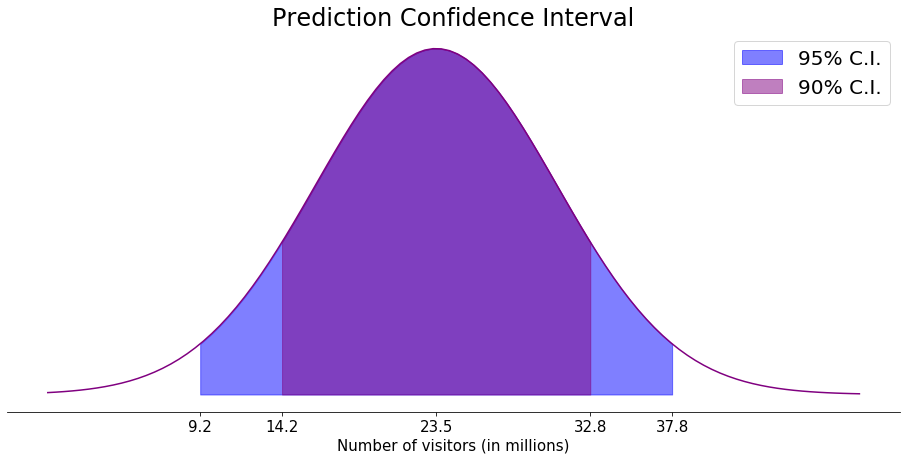

In [41]:
fig,ax1 = plt.subplots(figsize = (16,7))


plt.plot(np.linspace(0,upper_bound*1.3,100),
         stats.norm(estimated_ratio.mean(),
                    estimated_ratio.std()/np.sqrt(estimated_ratio.shape[0])).pdf(np.linspace(0,
                                                                                             upper_bound*1.3,
                                                                                             100)),color = 'purple')
plt.fill_between(np.linspace(lower_bound,upper_bound,100),stats.norm(estimated_ratio.mean(),
                                                    estimated_ratio.std()/np.sqrt(estimated_ratio.shape[0])).pdf(np.linspace(lower_bound,
                                                                                             upper_bound,
                                                                                             100)),color = 'blue',alpha = 0.5,label = '95% C.I.')

plt.fill_between(np.linspace(lower_bound_,upper_bound_,100),stats.norm(estimated_ratio.mean(),
                                                    estimated_ratio.std()/np.sqrt(estimated_ratio.shape[0])).pdf(np.linspace(lower_bound_,
                                                                                             upper_bound_,
                                                                                             100)),color = 'purple',alpha = 0.5,label = '90% C.I.')
plt.yticks([])
plt.xticks([lower_bound,lower_bound_,estimated_ratio.mean(),upper_bound_,upper_bound],[count_number(num_vis.loc[:,'num_reviews'],lower_bound).round(1),
                                                             count_number(num_vis.loc[:,'num_reviews'],lower_bound_).round(1),
                                                            count_number(num_vis.loc[:,'num_reviews'],estimated_ratio.mean()).round(1),
                                                             count_number(num_vis.loc[:,'num_reviews'],upper_bound_).round(1),
                                                            count_number(num_vis.loc[:,'num_reviews'],upper_bound).round(1)],
           
           fontsize = 15)
ax1.spines['left'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
plt.xlabel('Number of visitors (in millions)',fontsize = 15)
plt.title('Prediction Confidence Interval',fontsize = 24)
plt.legend(fontsize = 20)

### make the static heatmap

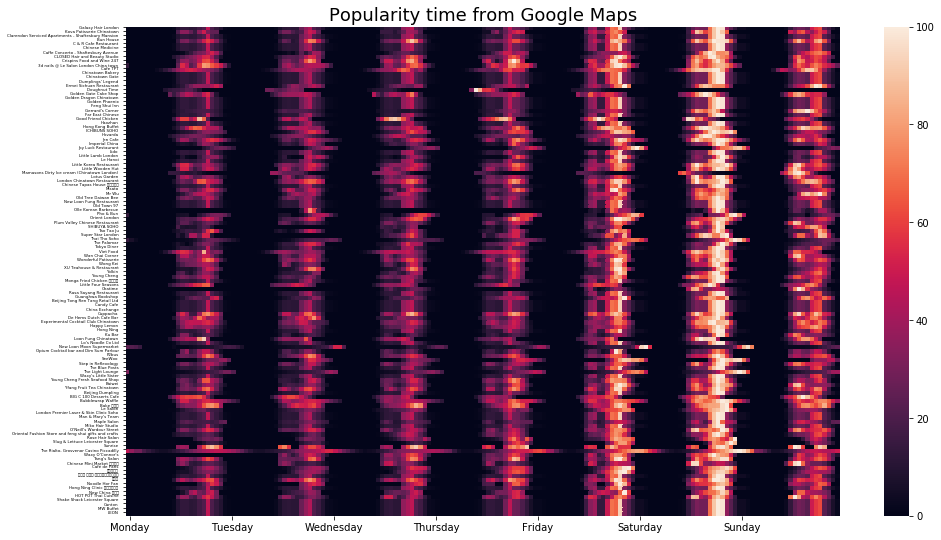

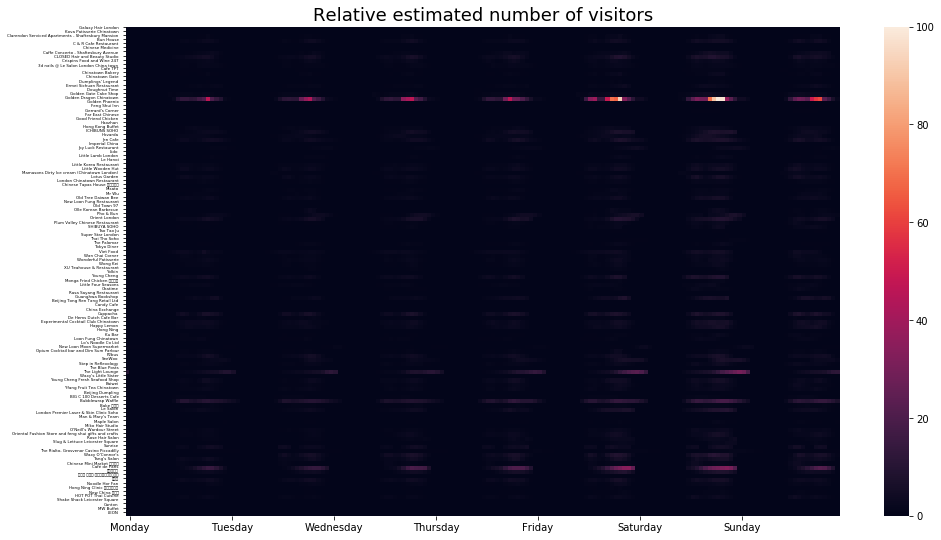

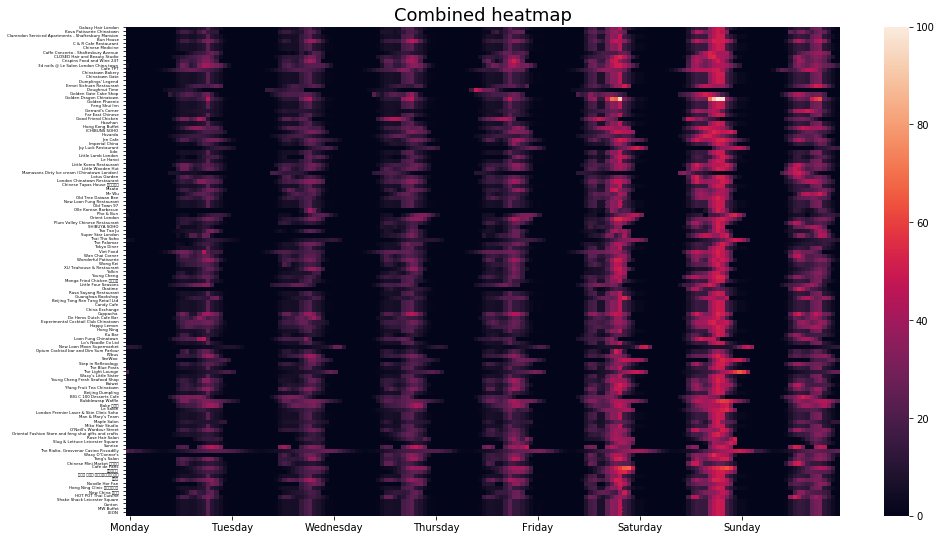

In [43]:
import seaborn as sns

plt.figure(figsize=(16,9))
sns.heatmap((org_numvis).fillna(0))
plt.title('Popularity time from Google Maps',fontsize = 18)
_ = plt.xticks(range(1,169,24),['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],rotation = 0)
_ = plt.yticks(range(0,118),jmetadata.name,fontsize = 4)
#plt.savefig(r'E:\UCL\BENV0114\CHINATOWN\heatm1.png',dpi = 320)

plt.figure(figsize=(16,9))
sns.heatmap((MinMaxNormal(coef_org,0,100)).fillna(0))
plt.title('Relative estimated number of visitors',fontsize = 18)
_ = plt.xticks(range(1,169,24),['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],rotation = 0)
_ = plt.yticks(range(0,118),jmetadata.name,fontsize = 4)
#plt.savefig(r'E:\UCL\BENV0114\CHINATOWN\heatm2.png',dpi = 320)

plt.figure(figsize=(16,9))
sns.heatmap((0.5*org_numvis+0.5*MinMaxNormal(coef_org,0,100)).fillna(0))
plt.title('Combined heatmap',fontsize = 18)
_ = plt.xticks(range(1,169,24),['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],rotation = 0)
_ = plt.yticks(range(0,118),jmetadata.name,fontsize = 4)

### make the dynamic heatmap

In [44]:
max_amount = float(jmetadata.loc[:,date_index].max().max())

for i in date_index:
    hmap = folium.Map(location=[51.511725,-0.131061], zoom_start=17 )
    hm_wide = HeatMap( list(zip(jmetadata.loc[:,'lat'],
                                jmetadata.loc[:,'lng'],
                                jmetadata.loc[:,i])),
                       min_opacity=0.0,
                       max_val=max_amount,
                       radius=20, blur=15, 
                       max_zoom=1, 
                     )
    hmap.add_child(hm_wide)
    os.chdir(path+'\ppl_map')
    hmap.save('heatmap_{0}-{1}.html'.format(i.weekday()+1,i.hour))

### save each heatmap as an image

In [45]:
import selenium
from selenium import webdriver
from PIL import Image

In [46]:
driver = webdriver.Chrome(path+'\chromedriver80.exe')

In [47]:
for i in date_index:
    hmapname = 'heatmap_{0}-{1}.html'.format(i.weekday()+1,i.hour)
    driver.get(path+'\ppl_map\{0}'.format(hmapname))
    pic = Image.open(BytesIO(driver.get_screenshot_as_png()))
    size = (12*pic.size[0]/pic.size[1],12)
    plt.figure(figsize = size)
    plt.imshow(np.array(pic))
    plt.axis('off')
    plt.title('Weekday:{0},Time:{1}:00'.format(i.weekday()+1,i.hour),fontsize = 32)
    plt.tight_layout()
    plt.savefig(path+'\screenshot\{0}-{1}.png'.format(i.weekday()+1,i.hour),dpi = 96)
    plt.close()
    print(i.weekday()+1,i.hour)

1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
2 13
2 14
2 15
2 16
2 17
2 18
2 19
2 20
2 21
2 22
2 23
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
3 11
3 12
3 13
3 14
3 15
3 16
3 17
3 18
3 19
3 20
3 21
3 22
3 23
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
4 10
4 11
4 12
4 13
4 14
4 15
4 16
4 17
4 18
4 19
4 20
4 21
4 22
4 23
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
5 10
5 11
5 12
5 13
5 14
5 15
5 16
5 17
5 18
5 19
5 20
5 21
5 22
5 23
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
6 10
6 11
6 12
6 13
6 14
6 15
6 16
6 17
6 18
6 19
6 20
6 21
6 22
6 23
7 0
7 1
7 2
7 3
7 4
7 5
7 6
7 7
7 8
7 9
7 10
7 11
7 12
7 13
7 14
7 15
7 16
7 17
7 18
7 19
7 20
7 21
7 22
7 23


In [48]:
driver.quit()

### save images into a gif

In [49]:
import imageio

In [52]:
duration = 0.125
frames = []
h,w = Image.open(path+'\screenshot\1-0.png').size
for i in date_index:
    frames.append(np.array(Image.open(path+'\screenshot\{0}-{1}.png'.format(i.weekday()+1,i.hour)).resize((h//4,w//4))))

imageio.mimsave(path+'\dy_.gif', frames, 'GIF', duration = duration)